# Predicting the value of football players using their Fifa statistics

**12th October 2019**

<img src="assets/fifa_img.png" style="height:400px,width:400px">
<br>



### Introduction

**Can the value of a football player be predicted from their playing attributes and meta data?**  
**Which factors are most important for determining a player's market value?**  
**Which players are over or undervalued compared to the market?**

In this notebook I will use a dataset of player attributes curated from the FIFA game's official [website](www.sofifa.com) in order to answer the three questions above\*. While factors like player form and team results may have a short-term impact on the perceived value of a player, ultimately the value of a player should be linked to their fundamental skills and attributes - how good are their skills compared to others? Being able to predict the value of each player and understanding the main drivers of the predictions has two main benefits:
1. Football teams/scouts can identify whether a target player is currently over or undervalued and what price they should be willing to pay for a player of that quality (regardless of current form).
2. Understanding which factors most affect value could inform up and coming players which skills are most in demand in the market and which skills they should focus on improving to increase their value.

For this analysis I will carry out some basic exploratory data analysis to gain a high level insight into the features in the dataset, before preparing the data for modeling (data cleaning; train/test split; scaling etc..) and evaluate different regression models to predict the value of football players in the dataset.

\*Note: The scrapy crawler to collect the data and scripts to clean up the data, and processed dataset for analysis are located in the **data_collection** and **data** folders in the repository.

### Analysis Assumptions
Main assumptions for this analysis:
- the value of football players is correlated to their skills set and abilities and meta data
- player value is not substantially driven by short-term form/performance (e.g. number of goals scored or clean sheets in the last 10 games etc.)
- player values are consistent/transferable across different leagues/countries. I.e. the value of each player is not dependent on the league in which they currently play
- other 'commercial' factors such as media presence/popularity do not affect the value of the player


## Executive Summary

Player attribute scores (e.g. passing, accuracy, stamina, acceleration etc.) and additional information (e.g. age, position, potential etc.) was collected from the SoFIFA website for the 2019 season. This information was used to develop a model to predict the value of each player. The distribution of player market values is very positively skewed with most players having relatively low valuations, but with a few exceptional players commanding a significant premium. This variable was log transformed to normalize the data and create the target variable for modeling - log(value). 

Initially, six regression models were tested on the full set of features (linear regression, multiple linear regression, decision trees, random forests and XGBoost) using GridSearchCV to tune the hyper-parameters. XGBoost with performed the best with a root mean squared error (RMSE) of 0.18. After interpreting the model output, individual playing attributes were found to be statistically significant but not economically significant. The playing attributes were combined into more general categories to reduce the model complexity but preserve some of the information contained in these features. Using the XGBoost algorithm on the new feature set, the performance of the model was marginally, yielding a RMSE of 0.17.

SHAP values were used to interpret the XGBoost model with overall rating, player potential and age found to be the most important features. Age had a non-linear relationship with the target variable with older players having a significantly lower predicted market value. Of the skills features, attacking skills (Crossing, finishing, short passing etc.) were the most important for increasing the predicted value.

The model was used to identify under and overvalued English players. The overvalued players included famous names and/or players who had played for big clubs in the past. This suggests that popularity/reputation, which was not included as a feature, could inflate the value of players above their fundamental skill.

------------------------

# Contents

**[1. Exploratory Data Analysis](#eda)**  
**[2. Modeling](#modeling)**  
**&nbsp;&nbsp;[2.1 Data Preparation](#data_prep)**  
**&nbsp;&nbsp;[2.2 Baseline Model](#baseline_model)**  
**&nbsp;&nbsp;[2.3 Multiple Linear Regression](#mlr)**   
**&nbsp;&nbsp;[2.4 Machine Learning Methods](#ml)**   
**[3. Model interpretation](#mi)**   
**&nbsp;&nbsp;[3.1 Feature Engineering](#fe)**  
**[4. Identifying over/under valued players](#iovp)**  
**[5. Conclusion](#conclusion)**


--------------------------

<a id='eda'></a>
## 1. Exploratory Data Analysis

EDA and initial feature cleaning/creation.


#### EDA Imports

In [1]:
#data manipulation
import pandas as pd
import numpy as np 
pd.options.display.max_columns = 999

#stats
from scipy.stats import pearsonr

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#other
import missingno as msno
from IPython.core.display import display, HTML

#list of player attributes (e.g passing accuracy, acceleration etc.)
from const import ATTRIBUTES

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load data

- Load the processed clean dataset for the "1. Processed" folder. 
- Remove the redundant columns for name/link/id etc. 
- keep columns with features we want for modeling
    - For this exercise we will not use the players' wages as a feature as it is likely directly correlated with 'value', therefore if you know the wage of the player it is not difficult to estimate the value. It is more useful to just use playing attributes (along with age and position) to assess the value of the player as that will enable us to draw inferences about which playing attributes are perceived as more valuable.
    
All player attributes are ranked from 1 to 100.

In [3]:
raw_df = pd.read_csv("data/1. processed/data_clean.csv")

df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

#select sensible features
df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']].copy()

display(HTML('<br><b>First five rows of the dataset:</b>'))
display(df.head())
print(f"Total number of rows: {df.shape[0]}\nTotal number of columns: {df.shape[1]}")

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,age,overall_rating,potential,Position,value_clean
0,47,39,71,72,21,59,32,28,66,64,73,85,61,67,62,44,86,61,88,24,81,75,35,56,39,68,68,84,75,6,7,8,15,9,19,77,88,LCB,13000000.0
1,60,65,64,76,68,77,59,68,70,77,79,77,76,72,90,85,79,86,76,77,90,69,70,67,68,68,73,70,64,5,12,6,13,14,20,75,84,CM,10000000.0
2,41,43,74,73,43,68,41,47,53,73,71,71,72,73,72,56,72,65,71,39,61,74,46,52,47,57,73,76,72,8,15,7,14,9,20,74,85,CB,8500000.0
3,18,19,17,25,15,14,22,18,29,25,49,54,69,65,65,25,75,39,51,20,23,17,15,66,23,45,25,16,21,73,70,69,74,77,20,73,87,GK,7500000.0
4,72,69,54,90,90,90,85,77,87,90,78,69,90,86,86,76,75,75,59,79,56,78,79,86,75,85,67,67,71,6,11,7,9,13,27,87,87,CM,51500000.0


Total number of rows: 13758
Total number of columns: 39


#### Check for missing data

Crossing             0
Finishing            0
Heading Accuracy     0
Short Passing        0
Volleys              0
Dribbling            0
Curve                0
FK Accuracy          0
Long Passing         0
Ball Control         0
Acceleration         0
Sprint Speed         0
Agility              0
Reactions            0
Balance              0
Shot Power           0
Jumping              0
Stamina              0
Strength             0
Long Shots           0
Aggression           0
Interceptions        0
Positioning          0
Vision               0
Penalties            0
Composure            0
Marking              0
Standing Tackle      0
Sliding Tackle       0
GK Diving            0
GK Handling          0
GK Kicking           0
GK Positioning       0
GK Reflexes          0
age                  0
overall_rating       0
potential            0
Position            39
value_clean          0
dtype: int64

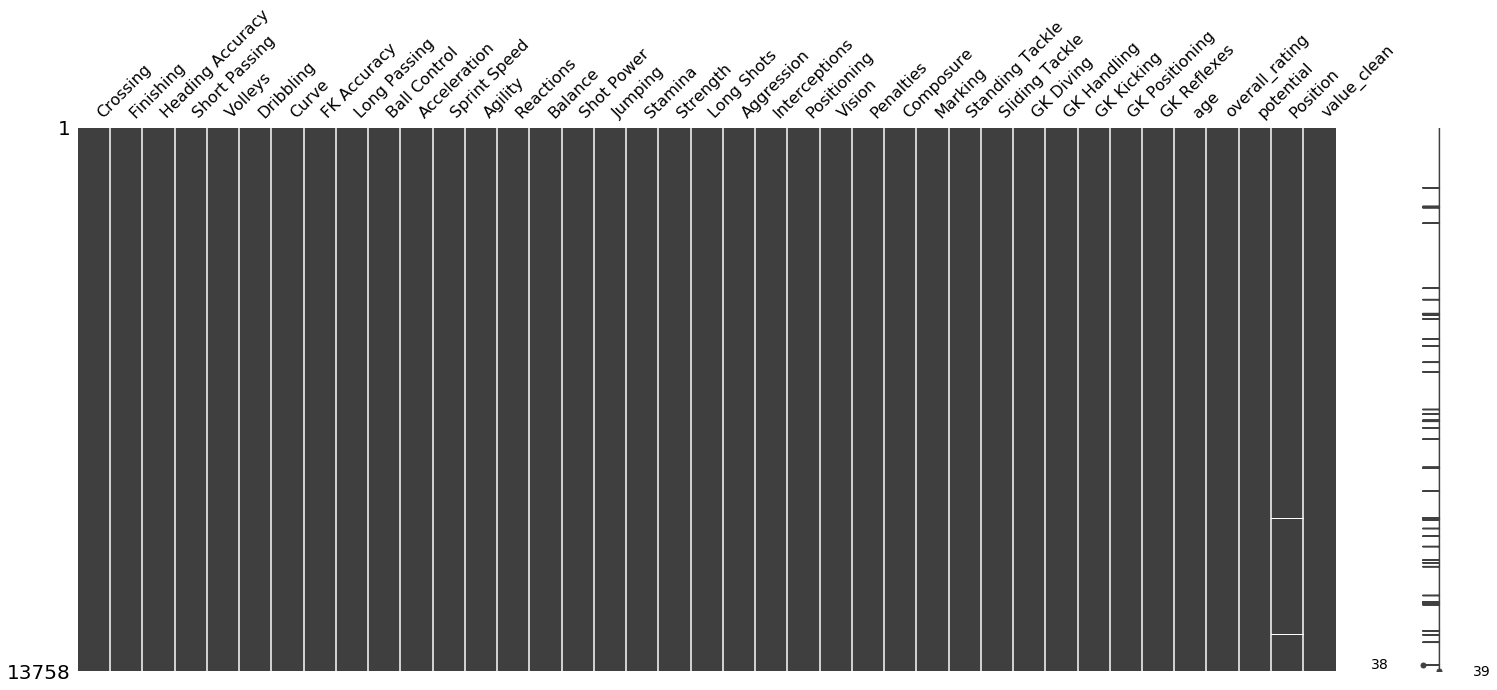

In [4]:
display(df.isnull().sum())

msno.matrix(df)
plt.show()

The 'position' feature which contains the position of the player has 39 missing datapoints. As this is only a very small subset of the total data (~13,800 total data points) I will just drop these datapoints.

In [5]:
#drop missing datapoints
df = df.loc[df['Position'].notnull()].copy()

### Feature Analysis

#### value_clean (target variable)

The value_clean column contains the value of each player in &euro;.

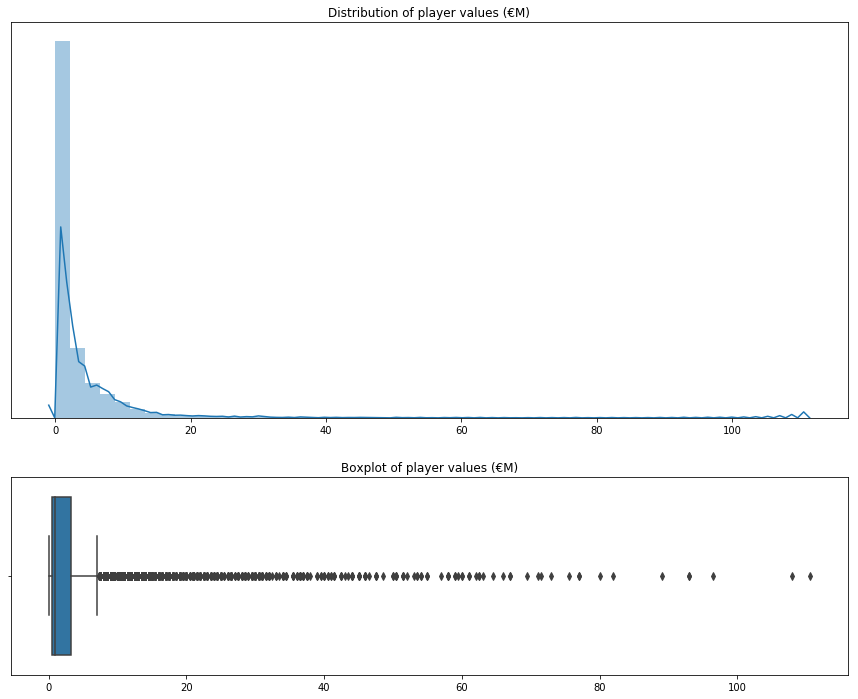

,value_clean
count,13719.000000
mean,3.163104
std,6.367481
min,0.010000
25%,0.475000
50%,0.950000
75%,3.200000
max,110.500000


In [6]:
def plot_distribution_and_stats(feature,name):
    """Helper function to plot distribution charts"""
    
    fig, ax = plt.subplots(nrows=2,figsize=(15,12),gridspec_kw={'height_ratios': [2, 1]})
    sns.distplot(feature,ax=ax[0])
    ax[0].set_title(f"Distribution of {name}")
    ax[0].set_yticks([])
    
    sns.boxplot(feature, ax=ax[1])
    ax[1].set_title(f"Boxplot of {name}")
    plt.show()
    
    display(feature.describe())
    
plot_distribution_and_stats(df[['value_clean']]/1_000_000,'player values (\N{euro sign}M)')

The player value is our target feature. The values of different players varies significantly, particularly for the top players whose value increases exponentially. The distribution shows that the variable is very positively skewed which could make prediction of very high value players difficult during modeling. 

The highest value player is &euro;110M and the lowest value player is just &euro;10,000. The mean is approximately &euro;3M but with a very large standard deviation of &euro;6M.

Due to these unfavorable distribution statistics, it will be a good idea to apply a log transformation on the data to reduce the variance in the target variable.

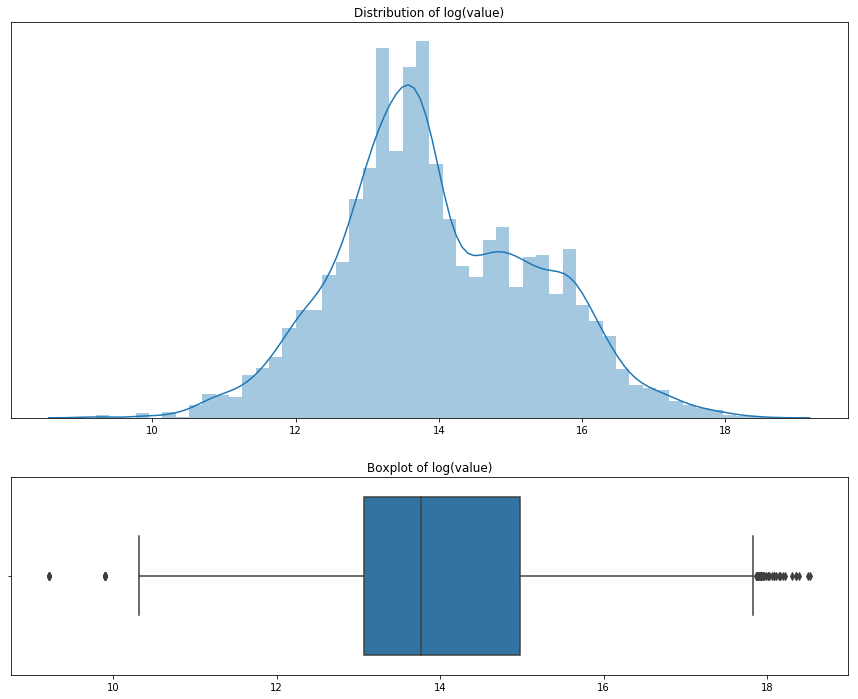

,value_clean_log
count,13719.000000
mean,13.974646
std,1.387843
min,9.210340
25%,13.071070
50%,13.764217
75%,14.978661
max,18.520526


In [7]:
#create log transformation
df['value_clean_log'] = np.log(df['value_clean'])

plot_distribution_and_stats(df[['value_clean_log']],'log(value)')

The target variable now looks more normally distributed and has a much lower standard deviation compared to the mean.

The box plot shows that most of the data is within the interquartile range with a few outliers at the top and bottom ends.

#### Age

The age of each player.

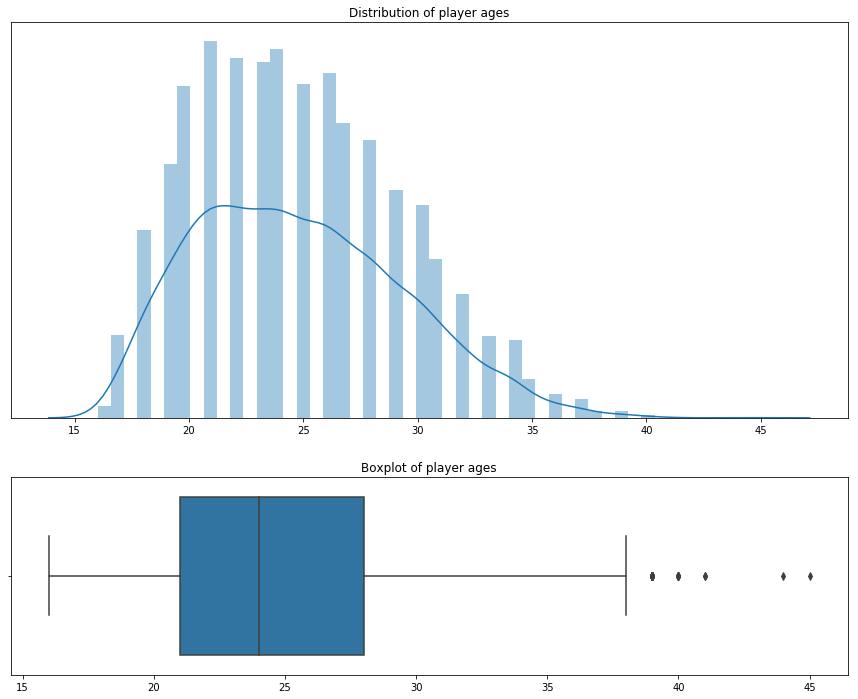

,age
count,13719.000000
mean,24.803120
std,4.516523
min,16.000000
25%,21.000000
50%,24.000000
75%,28.000000
max,45.000000


In [8]:
plot_distribution_and_stats(df[['age']],'player ages')

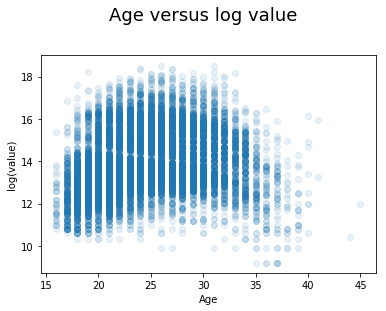

Pearson correlation = 0.18421933332162066


In [9]:
plt.scatter(x=df['age'],y=df['value_clean_log'],alpha=0.1)
plt.suptitle("Age versus log value",fontsize=18,y=1.05)
plt.xlabel("Age")
plt.ylabel("log(value)")
plt.show()


print(f"Pearson correlation = {pearsonr(df['value_clean_log'],df['age'])[0]}")

There seems to be a slight positive correlation between age and value (0.18) which suggests experience increases valuations, however, this is only up to a point. When the player age is approximately >35 then the values tend to decline. This makes sense as older players have fewer years left in their career so have less long term value for the club.

**Player position**

The favoured position of each player (e.g. ST, RM, CF, GK etc.).

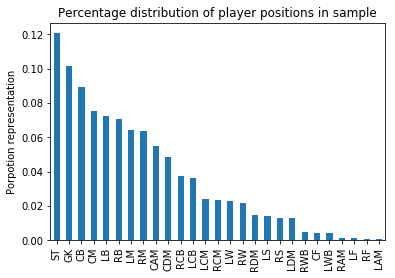

Number of unique positions = 27


In [10]:
df['Position'].value_counts(normalize=True).plot(kind='bar')
plt.title("Percentage distribution of player positions in sample")
plt.ylabel("Porpotion representation")
plt.show()

print(f"Number of unique positions = {df['Position'].nunique()}")

Position is the only categorical feature in the data.

Interestingly, striker is the most prevalent position in the dataset followed by goalkeepers.

There are 27 unique positions in the dataset. This is quite a lot for a categorical variable and it may be sensible to bucket these positions into more general categories (e.g. attacker, midfielder, defender etc..). I will create a new feature for these buckets.

In [11]:
def bucket_positions(pos):
    """Converts the specific position to a more general category"""
    
    POSITIONS_DICT = {
        'attack': ['CF', 'RF', 'LF', 'ST', 'LS', 'RS'],
        'midfield': ['CM', 'CAM', 'RM', 'CDM', 'LM', 'RCM', 'LCM', 'RDM', 'LDM', 'RAM', 'LAM', 'LW', 'RW'],
        'defence': ['LCB', 'CB', 'RB', 'RCB', 'LWB', 'LB', 'RWB'],
        'goal_keeper': ['GK']}

    for category, pos_list in POSITIONS_DICT.items():
        if pos in pos_list:
            return category
    
    return np.nan

In [12]:
df['Position_bucket'] = df['Position'].apply(bucket_positions)

del df['Position']

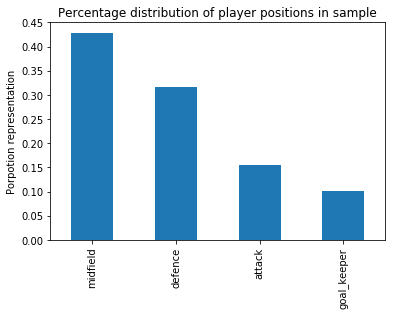

In [13]:
df['Position_bucket'].value_counts(normalize=True).plot(kind='bar')
plt.title("Percentage distribution of player positions in sample")
plt.ylabel("Porpotion representation")
plt.show()


This new feature is reduced to just four different categories.

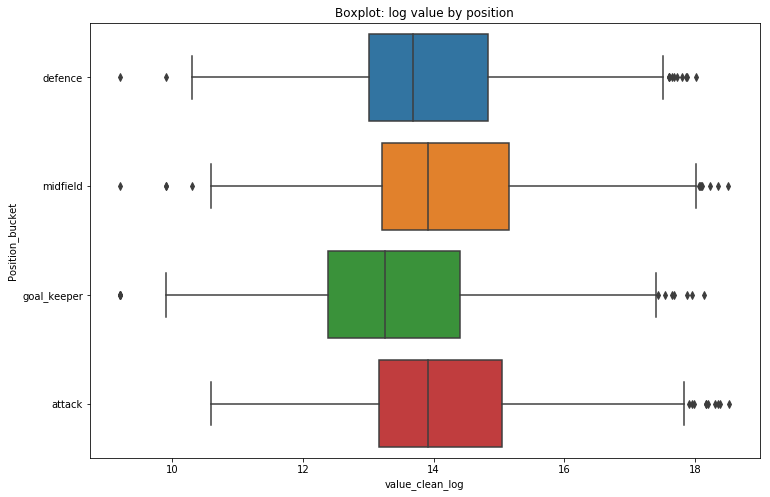

In [14]:
plt.figure(figsize=(12,8))
sns.boxplot(x='value_clean_log',y='Position_bucket',data=df)
plt.title("Boxplot: log value by position")
plt.show()

Looking at the distribution of valuations we see the distributions of log value are similar for each position category. Goal keepers tend to have lower values on average and attackers tend to have higher 'value' which would be expected. Attackers have more outliers at the higher end of their distribution. Note also that this is a log scale, so although the distributions are similar, in real terms, attackers are valued at significant premium.

**Player attribute features**

There are 34 different columns which describe the player's playing attributes.


In [15]:
ATTRIBUTES

['Crossing',
 'Finishing',
 'Heading Accuracy',
 'Short Passing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FK Accuracy',
 'Long Passing',
 'Ball Control',
 'Acceleration',
 'Sprint Speed',
 'Agility',
 'Reactions',
 'Balance',
 'Shot Power',
 'Jumping',
 'Stamina',
 'Strength',
 'Long Shots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'Standing Tackle',
 'Sliding Tackle',
 'GK Diving',
 'GK Handling',
 'GK Kicking',
 'GK Positioning',
 'GK Reflexes']

I would assume that a lot of these features will be highly correlated with each other (e.g. Acceleration and sprint speed or goal keeping attributes will be negatively correlated with attacking attributes such as shooting, dribbling etc.), there could be scope to reduce the number of these features if necessary to improve the model and reduce complexity.

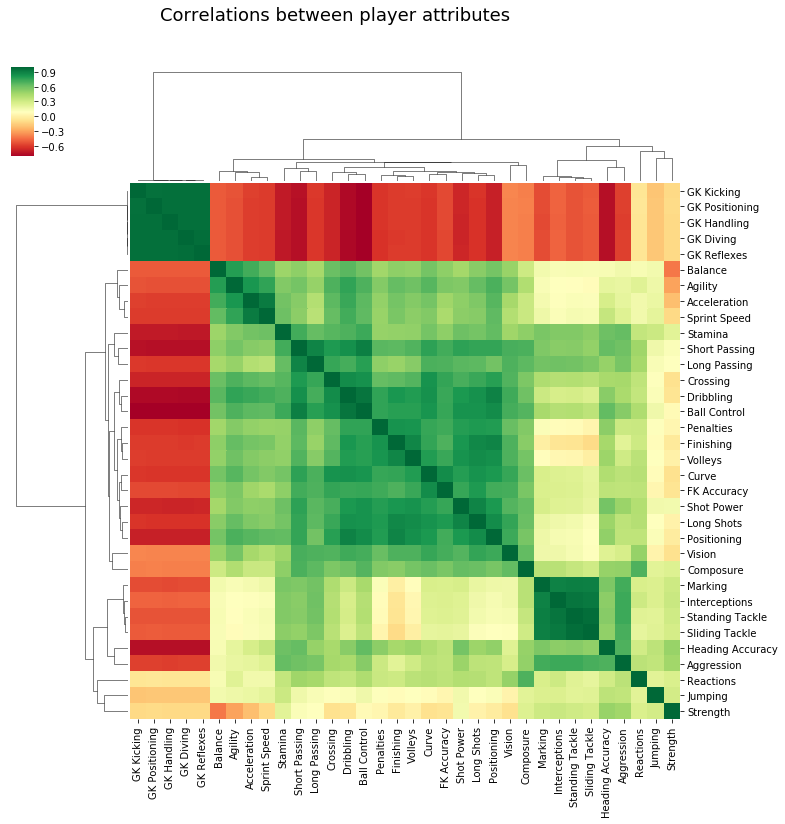

In [16]:
sns.clustermap(df[ATTRIBUTES].corr(),cmap='RdYlGn',figsize=(12,12))
plt.suptitle("Correlations between player attributes",fontsize=18,y=0.95)
plt.show()

There are a number of highly correlated features. Most notably, the goal keeping attributes (GK kicking, GK positioning, GK handling, GK diving and GK reflexes) are very correlated with each other and negatively correlated with the outfield attributes. Outfield attributes are generally all correlated with each other. Defending attributes (Marking, interceptions, standing tackle, sliding tackle etc) are very correlated with each other, however, the attacking attributes are not as strongly correlated. This shows that generally, goal keepers and defenders have a set of 'standard' skills whereas the attacking players have more specific skills sets (e.g. particularly good at volleying or crossing but not necessarily both.

**Player potential**

This is the overall rating that SOFIFA predicts to be the future potential for the player.

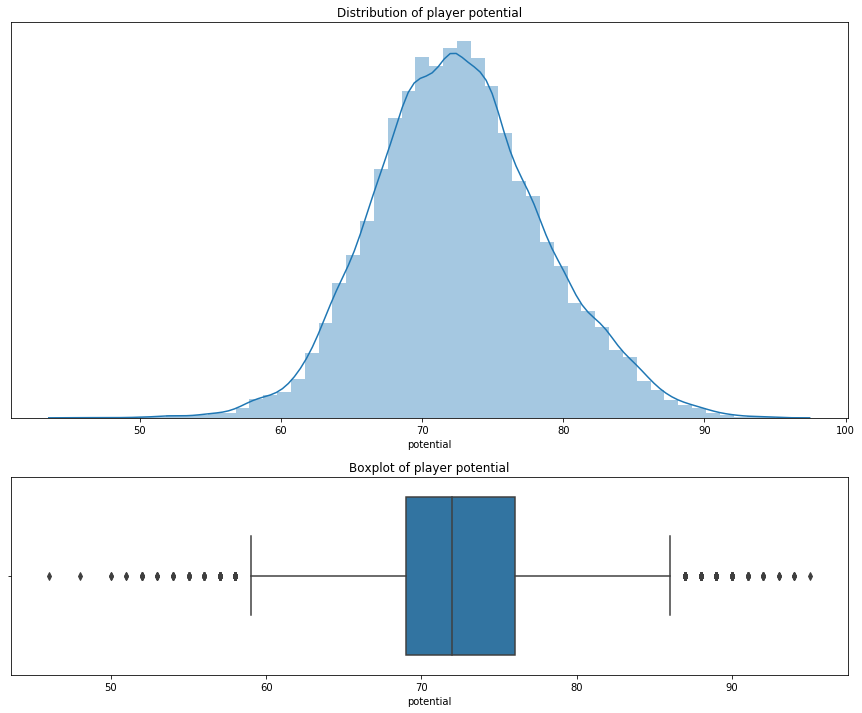

count    13719.000000
mean        72.657482
std          6.027961
min         46.000000
25%         69.000000
50%         72.000000
75%         76.000000
max         95.000000
Name: potential, dtype: float64

In [17]:
plot_distribution_and_stats(df['potential'],'player potential')

Player potential is pretty much normally distributed with a mean of 72.

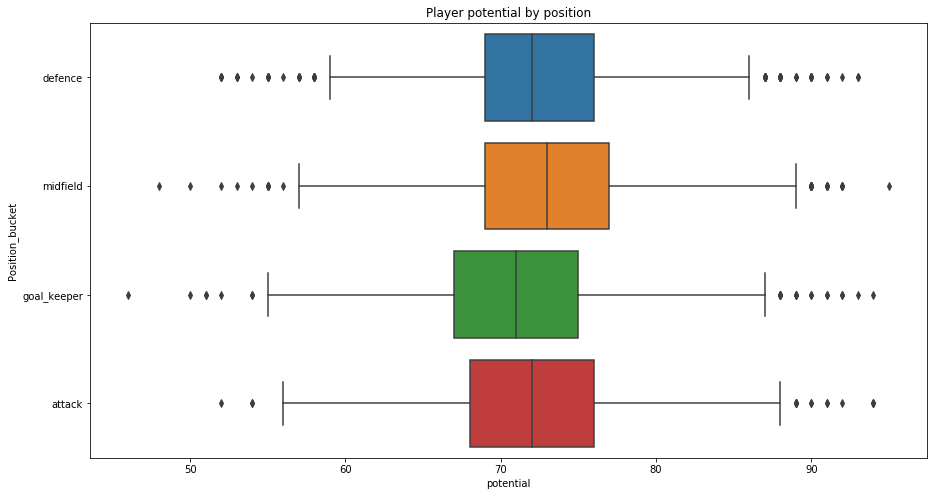

In [18]:
plt.figure(figsize=(15,8))
sns.boxplot(x='potential',y='Position_bucket',data=df)
plt.title("Player potential by position")
plt.show()

The player potential does not seem to be materially different for the different positions.

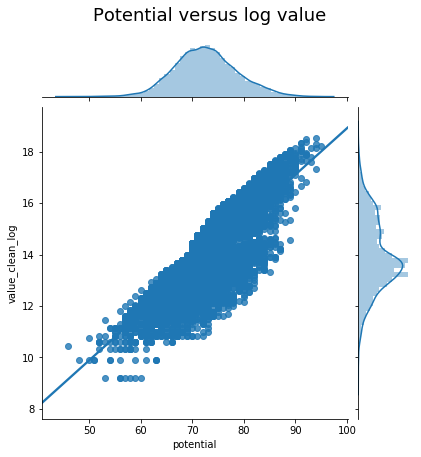

In [19]:
sns.jointplot(x='potential',y='value_clean_log',data=df,kind='reg')
plt.suptitle("Potential versus log value",fontsize=18,y=1.05)
plt.show()

There is a strong positive correlation between potential and the target variable, log(value).

Player potential and overall rating a probably very correlated, to check this we can plot potential versus overall rating.

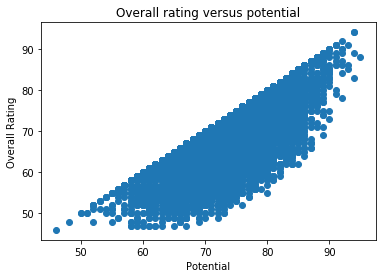

Pearson correlation = 0.6660520899052275


In [20]:
plt.scatter(x=df['potential'],y=df['overall_rating'])
plt.xlabel("Potential")
plt.ylabel("Overall Rating")
plt.title("Overall rating versus potential")
plt.show()

print(f"Pearson correlation = {pearsonr(df['potential'],df['overall_rating'])[0]}")

We can see that the overall rating is always lower than the player potential, which makes sense. However, the correlation is only 0.66, therefore it is probably useful to keep both features for modeling.

Another feature that could be of interest is the difference between the current player rating and the player potential. I will create this feature and call it 'potential_growth'. Players with higher growth potential may be of higher value for their current overall rating.

In [21]:
#create new feature
df['potential_growth'] = df['potential']-df['overall_rating']

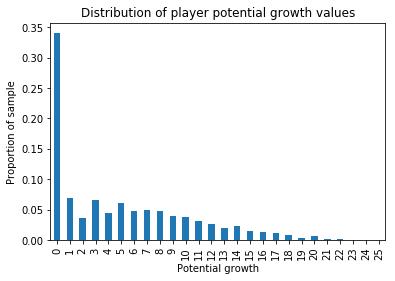

In [22]:
df['potential_growth'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Distribution of player potential growth values")
plt.ylabel("Proportion of sample")
plt.xlabel("Potential growth")
plt.show()

We can see that most players are already at their maximum potential (difference between potential and current overall rating = 0). The potential growth ranges up to 25 additional points.

To see how this new feature correlates to the target variable we can plot potential growth versus log(value) and also calculate the Pearson correlation. Growth potential is also likely to be correlated to the overall rating so we will also plot this relationship

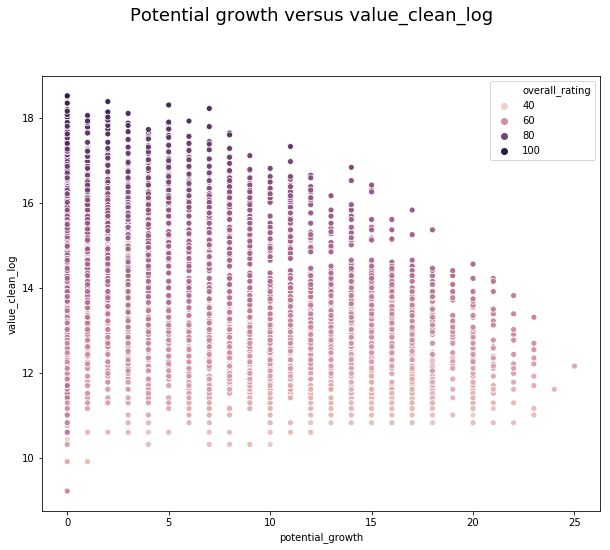

Pearson correlation = -0.31245629202124825


In [23]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='potential_growth',y='value_clean_log',data=df,hue='overall_rating')
plt.suptitle("Potential growth versus value_clean_log",fontsize=18,y=1)
plt.show()

print(f"Pearson correlation = {pearsonr(df['value_clean_log'],df['potential_growth'])[0]}")


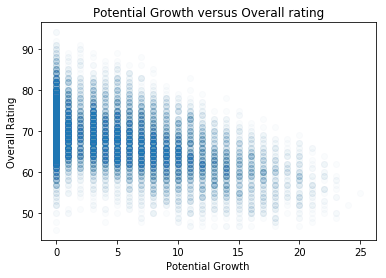

Pearson correlation = -0.5160447194481983


In [24]:
plt.scatter(x=df['potential_growth'],y=df['overall_rating'],alpha=0.02)
plt.title("Potential Growth versus Overall rating")
plt.xlabel("Potential Growth")
plt.ylabel("Overall Rating")
plt.show()
print(f"Pearson correlation = {pearsonr(x=df['potential_growth'],y=df['overall_rating'])[0]}")

Interestingly, the potential growth is negatively correlated with the log value which tells us that the higher the potential growth, the lower the current player value is. This is intuitive as players with high growth potential almost by definition must have a lower overall rating and thus lower current value. However, the plot of potential growth against log(value) shows a narrowing of the 'funnel' and lower variance in the values of players with higher growth potential suggesting that players with high growth potential are valued at a premium.

Looking at the overall rating versus potential growth chart the correlation is only -0.51 suggesting that the new feature contains new information and may be useful to add to the model.

In [25]:
#del df['potential_growth']

**Player overall rating**

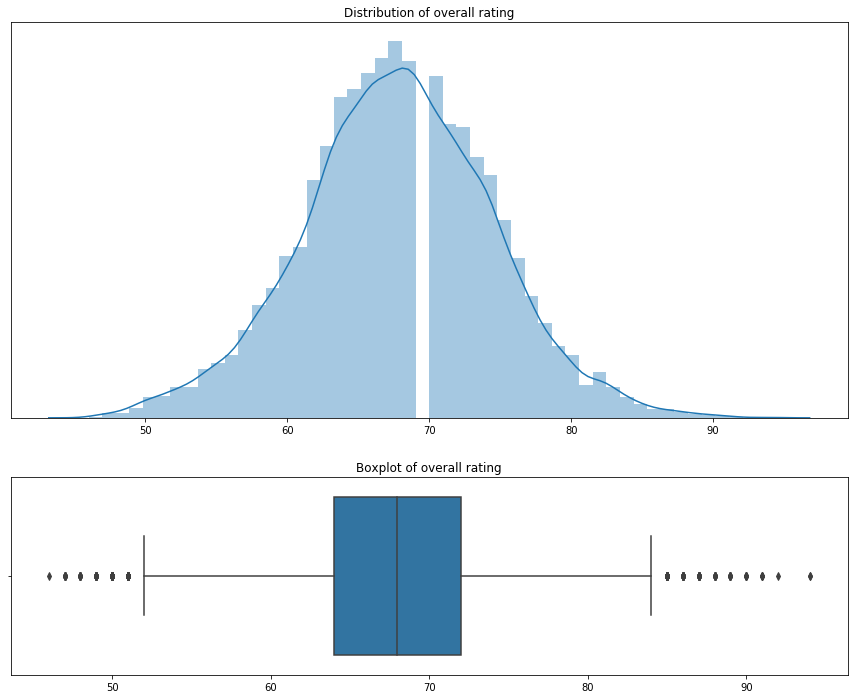

,overall_rating
count,13719.000000
mean,67.789416
std,6.723772
min,46.000000
25%,64.000000
50%,68.000000
75%,72.000000
max,94.000000


In [26]:
plot_distribution_and_stats(df[['overall_rating']],'overall rating')

Overall rating is normally distributed with a average of 68, min of 46 and max of 94. The distribution has long tails on both sides with low and high outliers.

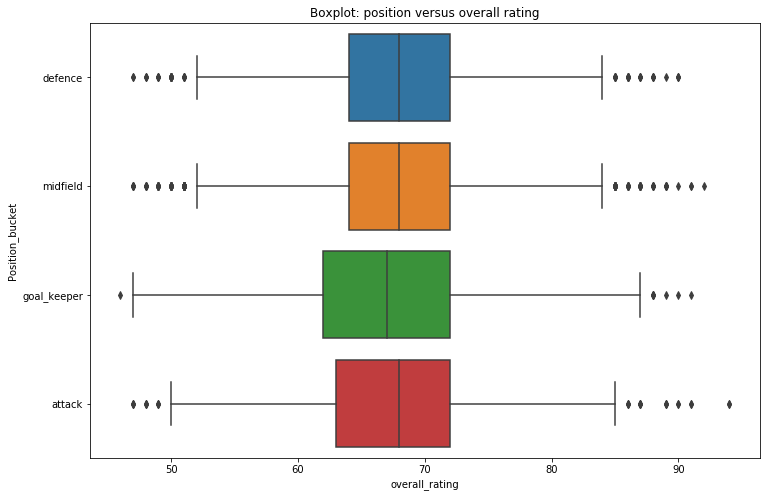

In [27]:
plt.figure(figsize=(12,8))
sns.boxplot(x='overall_rating',y='Position_bucket',data=df)
plt.title("Boxplot: position versus overall rating")
plt.show()

The overall ratings for each player position are very similar. Interestingly, this is in contrast to the boxplot of player position versus log value, where attackers had a higher value. This suggests that attackers come at a premium compared to their overall rating.

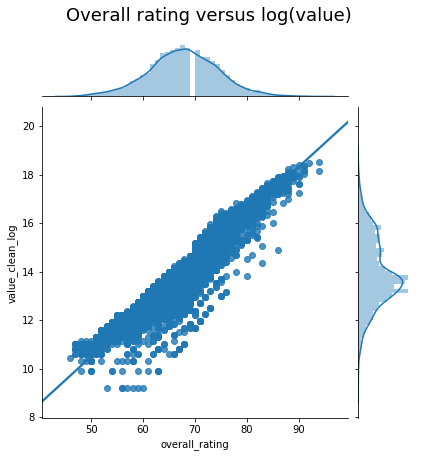

Pearson correlation = 0.9471756497749771
R2 = 0.8971417115266501


In [28]:
sns.jointplot(df['overall_rating'],
              df['value_clean_log'],
              kind="reg")
plt.suptitle("Overall rating versus log(value)",fontsize=18,y=1.05)
plt.show()
print(f"Pearson correlation = {pearsonr(df['overall_rating'],df['value_clean_log'])[0]}")
print(f"R2 = {pearsonr(df['overall_rating'],df['value_clean_log'])[0]**2}")


Overall rating is highly correlated with log value with an R2 of 0.89 and is likely to be the most predictive feature

### EDA summary

1. The target variable, player value, was log transformed to normalize the distribution.
2. Player position, a categorical attribute with high cardinality was converted into more general positions (e.g. attacker, defender, midfielder, goal keeper etc.). The distribution of player values for each position was similar, however, attacking players seem to be valued at a premium for their overall rating.
3. A new feature, potential growth, was created by calculating the difference between 'potential' and 'overall rating'. This new feature showed that players with a high growth potential tend to be valued at a premium to other players of the same overall rating.
4. The playing attributes (crossing, passing etc.) tend to be correlated strongly with each other but do not strongly correlate to player value. It may be necessary to combine some of these attributes together to reduce the model complexity. Of the playing attributes, reactions and composure seem to be the most correlated to value.
5. Player value increases with age, however, after about age 35 the value of players starts to drop.

A summary of the numerical feature correlations to the target variable (log(value)) are summarised below:

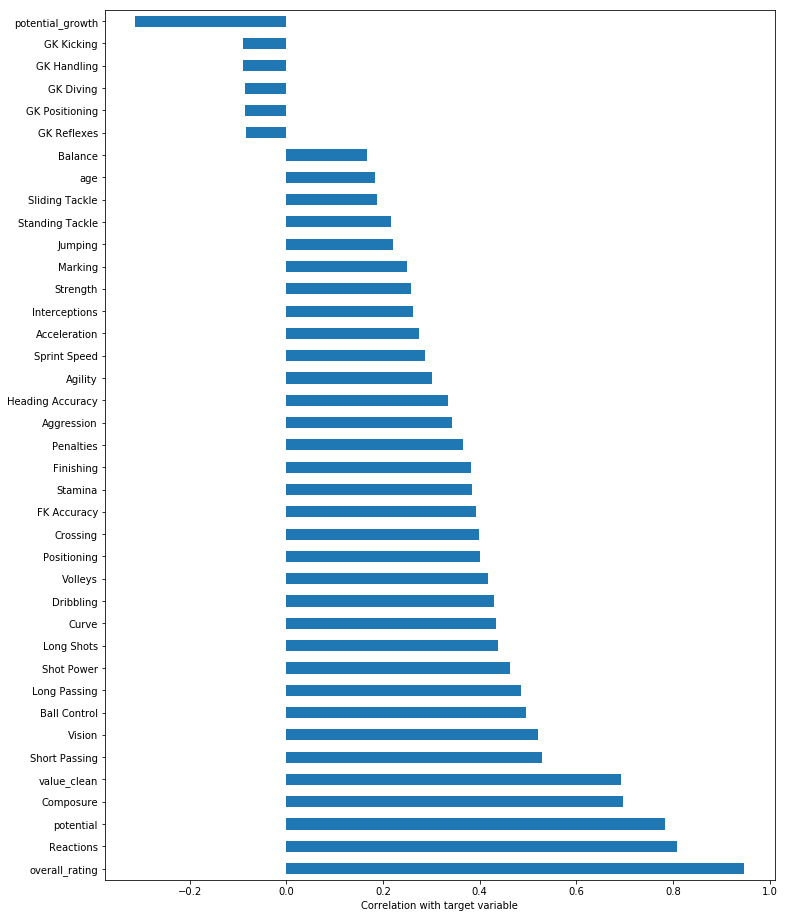

In [29]:
#correlation between each feature and the target variable (value_clean_log)
display(HTML("<b>Feature correlations to the target variable, log(value)</b>"))
df.corr()['value_clean_log'].sort_values(ascending=False).iloc[1:].plot(kind='barh',figsize=(12,16))
plt.xlabel("Correlation with target variable")
plt.show()

------------------------

<a id='modeling'></a>
# 2. Modeling

<a id='data_prep'></a>
## 2.1 Data Preparation

For modeling I will create a new function which loads the raw data and applies the data cleaning/feature creation steps carried out in the EDA. We will then create the test train split and a sklearn pipeline for feature scaling and processing.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#load in raw data again
def make_data_set():
    """Loads raw data and applies initial feature creation/processing steps"""
    
    #load raw data
    raw_df = pd.read_csv("data/1. processed/data_clean.csv")    
    df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

    #select sensible features
    df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']].copy()
    
   
    #drop missing position datapoints
    df = df.loc[df['Position'].notnull()].copy()
    
    #create player position buckets
    df['Position_bucket'] = df['Position'].apply(bucket_positions) 
    del df['Position']
    
    #create new feature for potential growth
    df['potential_growth'] = df['potential']-df['overall_rating']
    
    #log transform value_clean attribute
    df['target'] = np.log(df['value_clean'])
    del df['value_clean']
    
    #make sure no missing data
    assert df.isnull().sum().sum() == 0
    
    #shuffle the dataframe just incase there was any bias in the order that the data was collected
    df_shuffled = shuffle(df, random_state=0)

    #create train and test split
    return train_test_split(df_shuffled.iloc[:,:-1],
                            df_shuffled.iloc[:,-1],
                            test_size=0.33,
                            random_state=0)

In [31]:
#create training and final test sets
X_train, X_test, y_train, y_test = make_data_set()

<a id ='baseline_model' ></a>
## 2.2 Baseline model

To evaluate the effectiveness of the machine learning model we need to decide which accuracy metric to optimise for and also evaluate the model performance against a simple baseline model.

From the EDA section we discovered that overall rating had the highest correlation with the value of the player (0.94). Therefore the simplest model with good performance is likely to be a linear regression of overall rating versus log(value).

We will optimise for RSME (root mean squared error) because we want to be able to predict the value of a player, in particular the players which are significantly under of over valued. Therefore we want to choose a metric which penalises very bad predictions more than predictions which are only marginally off the actual value. RMSE is given by the following equation:

$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{e^2}}$$

Where $e$ is the error (difference between predicted and actual).  

As this is a squared term, large errors will be amplified and increase the RSME and lead to a worse performance of the model.

In [32]:
#dict to store modeling results
model_results = {}

#claculate adjusted r-squared
def calc_adj_r2(training_data,r2):
    """calculates the adjusted r2 for the model"""
    num_data_points = len(training_data)
    num_features = len(training_data.columns)
    return  1-((1-r2)*(num_data_points-1)/(num_data_points-num_features-1))

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = X_train['overall_rating'].values.reshape(-1,1)
y = y_train.values.reshape(-1,1)

baseline_model = LinearRegression()
baseline_model.fit(x,y)

baseline_pred = baseline_model.predict(X_train['overall_rating'].values.reshape(-1,1))
baseline_RMSE = np.sqrt(mean_squared_error(y_train, baseline_pred))
baseline_r2 = r2_score(y_train,baseline_pred)
baseline_adj_r2 = calc_adj_r2(X_train[['overall_rating']],baseline_r2)

#add result to model_results dictionary
model_results['baseline model (linear regression)'] = {'rmse':baseline_RMSE,
                                                      'adj. r2':baseline_adj_r2}
pd.DataFrame.from_dict(model_results,orient='index')

,rmse,adj. r2
baseline model (linear regression),0.438973,0.900383


The baseline linear regression gives a RMSE of 0.43 and an R-squared score of 0.90. This is already reasonably good model, however, there is still room for improvement, and it also does not give any insight into other variables which could affect the value of each player.

<a id ='mlr'></a>
## 2.3 Multiple Linear Regression


In [34]:
#create dummy variables for multiple linear regression 
X_train_mlr = pd.get_dummies(X_train,drop_first=True)
X_test_mlr = pd.get_dummies(X_test,drop_first=True)

X_train_mlr.head()

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,age,overall_rating,potential,potential_growth,Position_bucket_defence,Position_bucket_goal_keeper,Position_bucket_midfield
104,54,55,34,68,48,68,58,50,60,71,74,66,77,60,83,59,51,64,43,61,53,44,59,62,48,62,37,45,41,12,11,8,12,6,18,66,82,16,0,0,1
3367,83,72,42,73,73,76,83,84,72,74,76,74,84,73,73,83,62,71,61,81,53,35,71,83,85,77,42,21,20,10,7,14,7,10,31,76,76,0,0,0,1
4816,60,62,54,62,71,72,65,45,59,68,75,77,69,62,58,71,60,65,70,63,51,33,68,62,56,63,32,31,30,11,8,13,8,8,21,67,75,8,0,0,1
11395,39,62,44,47,50,66,50,51,37,68,73,78,73,61,71,61,33,48,59,63,46,38,67,46,62,44,41,20,22,8,9,13,6,13,24,59,65,6,0,0,1
11263,51,54,47,63,45,63,50,51,53,64,67,63,69,54,71,59,55,60,62,49,40,26,53,58,48,56,28,39,45,15,7,11,11,12,24,60,64,4,0,0,1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.179e+05
Date:                Tue, 15 Oct 2019   Prob (F-statistic):               0.00
Time:                        08:41:28   Log-Likelihood:                -320.60
No. Observations:                9191   AIC:                             721.2
Df Residuals:                    9151   BIC:                             1006.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Crossing                       -0.0014      0.000     -3.675      0.000      -0.002      -0.001
Finishing                       0.0010      0.000      2.164      0.031    9.22e-05       0.002
Heading Accuracy                0.0024      0.000      6.129      0.000       0.002       0.003
Short Passing                   0.0010      0.001      1.484      0.138      -0.000       0.002
Volleys                         0.0006      0.000      1.467      0.143      -0.000       0.001
Dribbling                       0.0001      0.001      0.215      0.830      -0.001       0.001
Curve                           0.0002      0.000      0.584      0.559      -0.001       0.001
FK Accuracy                     0.0009      0.000      2.787      0.005       0.000       0.002
Long Passing                   -0.0003      0.000     -0.604      0.546      -0.001       0.001
Ball Control                   -0.0024      0.001     -3.200      0.001      -0.004      -0.001
Acceleration                    0.0013      0.001      2.375      0.018       0.000       0.002
Sprint Speed                    0.0004      0.001      0.702      0.483      -0.001       0.001
Agility                        -0.0002      0.000     -0.569      0.569      -0.001       0.001
Reactions                    9.072e-05      0.001      0.142      0.887      -0.001       0.001
Balance                         0.0015      0.000      4.352      0.000       0.001       0.002
Shot Power                  -9.341e-05      0.000     -0.231      0.817      -0.001       0.001
Jumping                     -7.115e-05      0.000     -0.256      0.798      -0.001       0.000
Stamina                         0.0015      0.000      4.428      0.000       0.001       0.002
Strength                        0.0015      0.000      4.359      0.000       0.001       0.002
Long Shots                     -0.0007      0.000     -1.590      0.112      -0.002       0.000
Aggression                     -0.0005      0.000     -1.595      0.111      -0.001       0.000
Interceptions                  -0.0003      0.000     -0.696      0.486      -0.001       0.001
Positioning                     0.0013      0.000      2.987      0.003       0.000       0.002
Vision                          0.0002      0.000      0.411      0.681      -0.001       0.001
Penalties                       0.0005      0.000      1.440      0.150      -0.000       0.001
Composure                      -0.0017      0.000     -3.804      0.000      -0.003      -0.001
Marking                        -0.0016      0.000     -4.389      0.000      -0.002      -0.001
Standing Tackle                 0.0007      0.001      1.072      0.284      -0.001       0.002
Sliding Tackle                 -0.0009      0.001     -1.469      0.142      -0.002       0.000
GK Diving  

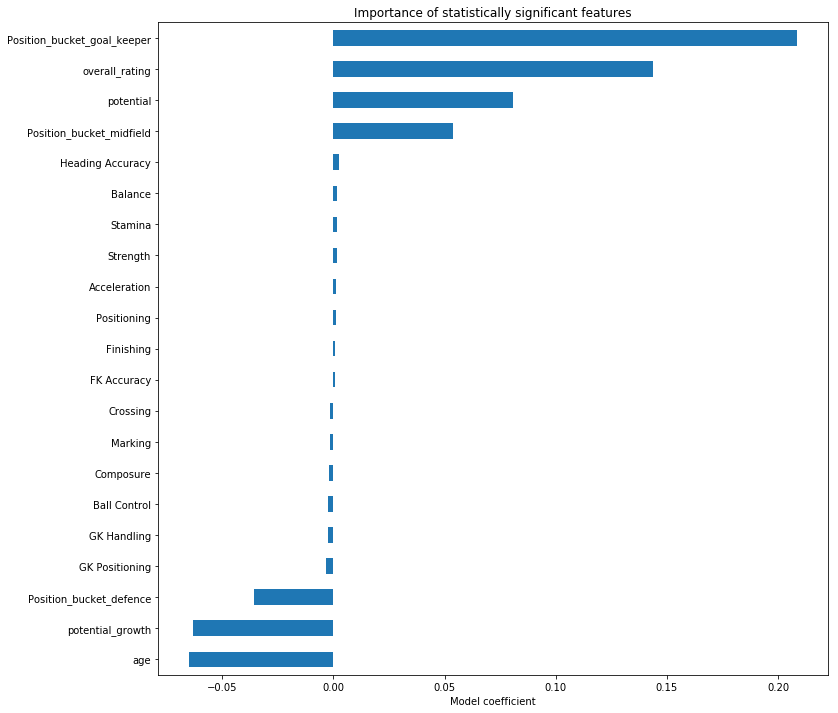

,rmse,adj. r2
Multiple Linear Regression,0.250560,0.967403
baseline model (linear regression),0.438973,0.900383


In [35]:
import statsmodels.api as sm

mlr_model = sm.OLS(y_train,X_train_mlr).fit()
mlr_pred = mlr_model.predict(X_train_mlr)

mlr_RMSE = np.sqrt(mean_squared_error(y_train, mlr_pred))
mlr_r2 = r2_score(y_train,mlr_pred)
mlr_adj_r2 = calc_adj_r2(X_train_mlr,mlr_r2)


display(HTML("<h3>Regression Results</h3>"))
display(mlr_model.summary())

display(HTML("<h3>Statistically Significant Feautre Importances</h3>"))
plt.figure(figsize=(12,12))
mlr_model.params[mlr_model.pvalues<0.05].sort_values().plot(kind='barh')
plt.title("Importance of statistically significant features")
plt.xlabel("Model coefficient")
plt.show()

display(HTML(f"""<h4>Statistically insignificant variables</h4><p>{mlr_model.params[mlr_model.pvalues>0.05].index.tolist()}</p>"""))
        
        
#add result to model_results dictionary
model_results['Multiple Linear Regression'] = {'rmse':mlr_RMSE,
                                              'adj. r2':mlr_adj_r2}

display(HTML("<h3>Model comparison</h3>"))
display(pd.DataFrame.from_dict(model_results,orient='index'))

The output above shows the multiple linear regression results when using all the available features.

The multiple linear regression model is an improvement on the baseline model, with a RMSE of 0.25. The adjusted r2 is also higher than the simple linear regression, indicating that although the model is more complex, the added complexity improves the predictive performance of the model.

Overall rating, potential, potential growth and age have high absolute feature importance as expected from the EDA analysis. The player position also appears to have a big impact on the model's predictions. Most player attributes are statistically insignificant for predicting player value and for those that are statistically significant they have very low feature importances. This suggests that these features for a multiple linear regression model and complexity without improving the performance and should be considered as candidates for dropping from the model.

### Multiple Linear Regression - Backward elimination

To improve the multiple linear regression model we can try a backward elimination technique which sequentially removes variables which are statistically insignificant from the model. This helps to reduce the model complexity whilst maintaining the significant variables.

In [36]:
#Backward Elimination
#Iteratively fit model and remove statistically insignificant variables

cols = list(X_train_mlr.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train_mlr[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

mlr_be_selected_features = cols
print(mlr_be_selected_features)

['Heading Accuracy', 'Volleys', 'FK Accuracy', 'Ball Control', 'Reactions', 'Balance', 'Strength', 'Positioning', 'Marking', 'Sliding Tackle', 'GK Handling', 'GK Positioning', 'age', 'overall_rating', 'potential', 'potential_growth', 'Position_bucket_defence']


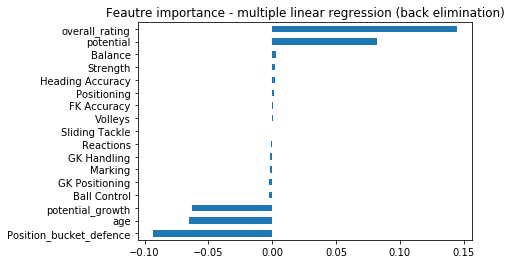

In [37]:
mlr_be_model = sm.OLS(
    y_train, X_train_mlr[mlr_be_selected_features]).fit()

mlr_be_pred = mlr_be_model.predict(
    X_train_mlr[mlr_be_selected_features])

mlr_be_RMSE = np.sqrt(
    mean_squared_error(y_train, mlr_be_pred))

mlr_be_r2 = r2_score(y_train, mlr_be_pred)
mlr_be_adj_r2 = calc_adj_r2(X_train_mlr[mlr_be_selected_features],mlr_be_r2)

mlr_be_model.params.sort_values().plot(kind='barh')
plt.title("Feautre importance - multiple linear regression (back elimination)")
plt.show()

In [38]:
model_results['Multiple Linear Regression - Backward Elimination'] = {'rmse':mlr_be_RMSE,
                                                                     'adj. r2':mlr_be_adj_r2}

pd.DataFrame.from_dict(model_results,orient='index').sort_values('rmse')

,rmse,adj. r2
Multiple Linear Regression,0.250560,0.967403
Multiple Linear Regression - Backward Elimination,0.252326,0.967028
baseline model (linear regression),0.438973,0.900383


The multiple linear regression using a reduced set of features gives a very similar rmse and adjusted r-squared to the regression model which included all features. As the performance is very similar, but the model complexity of the reduced model is lower, it should be considered as a better candidate.

<a id='ml'></a>
## 2.4 Machine Learning Methods

For data preprocessing, the numeric attributes will be scaled using a z-score transformation and the single categorical attribute (position_bucket) will be one-hot encoded.

For this exercise I will compare the performance of three ML models:
- Decision trees
- Random forests 
- XGBoost

To see which model performs the best, I will use cross fold validation with gridsearch CV for hyper parameter tuning and record the best performing model. 

I will use sklearn Pipelines to scale and process the data into the correct format for each of the ML algorithms. This is a more robust method for data preparation and ensures repeatability across different models.


**Set up pipelines**

- general preprocessing

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

assert len(numeric_features.append(categorical_features))==len(X_train.columns)


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

nominal_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

#apply transformations to numerical and categroical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', nominal_categorical_transformer, categorical_features)])

- pipelines for each regression model

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost
from xgboost import XGBRegressor


pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeRegressor(random_state=0))
])

pipe_dt_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('dt', DecisionTreeRegressor(random_state=0))
])


pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=0))
])


pipe_rf_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('rf', RandomForestRegressor(random_state=0))
])


pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbrg', XGBRegressor())
])


pipe_xgb_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('xgbrg', XGBRegressor())
])

- Metric

In [41]:
from sklearn.metrics import mean_squared_error
def root_mean_squared_error(y_true, y_pred):
    """Root mean squared error regression loss"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [42]:
from sklearn.metrics import make_scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

- Grid search

In [43]:
CV_FOLDS = 5
N_JOBS = -1
VERBOSE = 1

In [44]:
dt_param_grid = {"dt__min_samples_split": [10, 20, 40],
      "dt__max_depth": [2, 6, 8],
      "dt__min_samples_leaf": [20, 40, 100],
      "dt__max_leaf_nodes": [5, 20, 100],
     }

gs_dt = GridSearchCV(estimator=pipe_dt,
                     param_grid=dt_param_grid,
                     scoring=rmse_scorer,
                     n_jobs=N_JOBS,
                     verbose=VERBOSE,
                     cv=CV_FOLDS)

gs_dt_pca = GridSearchCV(estimator=pipe_dt_pca,
                         param_grid=dt_param_grid,
                         scoring=rmse_scorer,
                         n_jobs=N_JOBS,
                         verbose=VERBOSE,
                         cv=CV_FOLDS)

In [45]:
rf_param_grid = {"rf__min_samples_split": [10, 20, 40],
                  "rf__max_depth": [2, 6, 8],
                  "rf__min_samples_leaf": [20, 40, 100],
                  "rf__max_leaf_nodes": [5, 20, 100],
                 }

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid= rf_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS) 

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
                     param_grid= rf_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS) 

In [46]:
xgb_param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500, 1000],
    "xgbrg__learning_rate": [0.1, 0.5, 1]
}


gs_xgb = GridSearchCV(estimator=pipe_xgb,
                     param_grid= xgb_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS) 

gs_xgb_pca = GridSearchCV(estimator=pipe_xgb_pca,
                     param_grid= xgb_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS)  

- train all models

In [47]:
from sklearn.externals import joblib

# List of pipelines for ease of iteration
grids = [gs_dt, gs_dt_pca, gs_rf, gs_rf_pca, gs_xgb, gs_xgb_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Decision Tree', 1: 'Decision Tree w/PCA', 
             2: 'Random Forest', 3: 'Random Forest w/PCA', 
             4: 'XGBoost', 5: 'XGBoost w/PCA'}


# Fit the grid search objects
print('Performing model optimizations...')
best_rmse = 1.0
best_model = 0
best_gs = ''

for idx, gs in enumerate(grids):
    print(f"\nEstimator: {grid_dict[idx]}")
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print(f"Best params: {gs.best_params_}")
    # Best training data accuracy
    print(f"Best training accuracy: {-gs.best_score_}")
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE of best {grid_dict[idx]} model on all training data: {rmse}")
    #Add result to dictionary of model results
    r2 = r2_score(y_test,y_pred)
    model_results[grid_dict[idx]]= {'rmse': rmse,
                                   'adj. r2': calc_adj_r2(X_test,r2)}

    # Track best (highest test accuracy) model
    if rmse < best_rmse:
        best_rmse = rmse
        best_gs = gs
        best_model = idx
        print(f"\nClassifier with best test set accuracy: {grid_dict[best_model]}")

# Save best grid search pipeline to file
dump_file = 'best_gs_model.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print(f"\nSaved {grid_dict[best_model]} grid search pipeline to file: {dump_file}")

Performing model optimizations...

Estimator: Decision Tree
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   22.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best params: {'dt__max_depth': 8, 'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 10}
Best training accuracy: 0.210086813549119
RMSE of best Decision Tree model on all training data: 0.197168277359902

Classifier with best test set accuracy: Decision Tree

Estimator: Decision Tree w/PCA
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best params: {'dt__max_depth': 8, 'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 10}
Best training accuracy: 0.5333025062084288
RMSE of best Decision Tree w/PCA model on all training data: 0.5334547606630075

Estimator: Random Forest
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.0min finished


Best params: {'rf__max_depth': 8, 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 20, 'rf__min_samples_split': 10}
Best training accuracy: 0.18066137626414985
RMSE of best Random Forest model on all training data: 0.16790229494325498

Classifier with best test set accuracy: Random Forest

Estimator: Random Forest w/PCA
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   36.2s finished


Best params: {'rf__max_depth': 8, 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 20, 'rf__min_samples_split': 40}
Best training accuracy: 0.43284166709794464
RMSE of best Random Forest w/PCA model on all training data: 0.4257461455662577

Estimator: XGBoost
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.7min finished


[08:46:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params: {'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}
Best training accuracy: 0.09708663717478175
RMSE of best XGBoost model on all training data: 0.07935367591959631

Classifier with best test set accuracy: XGBoost

Estimator: XGBoost w/PCA
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished


[08:47:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params: {'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}
Best training accuracy: 0.28972971734854147
RMSE of best XGBoost w/PCA model on all training data: 0.278596156826883

Saved XGBoost grid search pipeline to file: best_gs_model.pkl


In [48]:
display(HTML("<h4>Model Results</h4>"))
pd.DataFrame.from_dict(model_results,orient='index')

,rmse,adj. r2
Decision Tree,0.197168,0.979451
Decision Tree w/PCA,0.533455,0.849580
Multiple Linear Regression,0.250560,0.967403
Multiple Linear Regression - Backward Elimination,0.252326,0.967028
Random Forest,0.167902,0.985099
Random Forest w/PCA,0.425746,0.904190
XGBoost,0.079354,0.996672
XGBoost w/PCA,0.278596,0.958974
baseline model (linear regression),0.438973,0.900383


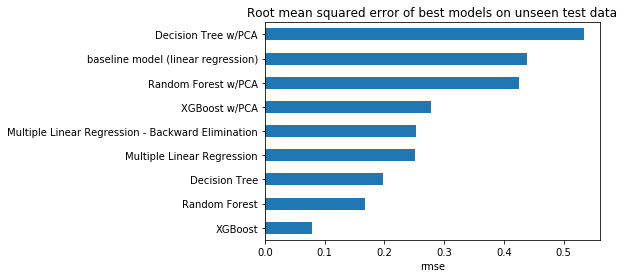

In [49]:
pd.DataFrame.from_dict(model_results,orient='index')['rmse'].sort_values().plot(kind='barh')
plt.title("Root mean squared error of best models on unseen test data")
plt.xlabel("rmse")
plt.show()

XGboost had the best performance of all the models with a root mean squared error of 0.079 on the completely unseen test data.

This is a big improvement on the initial baseline regression model and multiple linear regression models. I will use the XGBoost model as the candidate for further investigation.

<a id='mi'></a>
# 3. Model Interpretation 

In [50]:
#load best model
best_model = joblib.load("best_gs_model.pkl")
print(f"\nBest parameters:\n\t{best_model.best_params_}")

[08:48:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Best parameters:
	{'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}


The model is currently stored as a sklearn pipeline object. The xgboost and SHAP libraries do not currently support this object type (I am not sure if there is a work around?!), therefore I will retrain the model again using the best parameters manually and store as an XGBoost model object.

In [51]:
#create training dataset
X_train_shap = X_train.copy()
X_train_shap = pd.get_dummies(X_train_shap,drop_first=True)

scaler = StandardScaler().fit(X_train_shap[numeric_features])
X_train_shap[numeric_features] = scaler.transform(X_train_shap[numeric_features])


#create test dataset
X_test_shap = X_test.copy()
X_test_shap = pd.get_dummies(X_test_shap,drop_first=True)
#use scaler from training set
X_test_shap[numeric_features] = scaler.transform(X_test_shap[numeric_features])


#train model
xgb_model = XGBRegressor(learning_rate= 0.1, 
                              n_estimators= 1000).fit(X_train_shap,y_train)

[08:48:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


To assess the feature importances for the xgboost model we can use the inbuilt *plot_impotances* function. In the documentation, there are three different ways to calculate the feature importance:
- ”weight” is the number of times a feature appears in a tree
- ”gain” is the average gain of splits which use the feature
- ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split


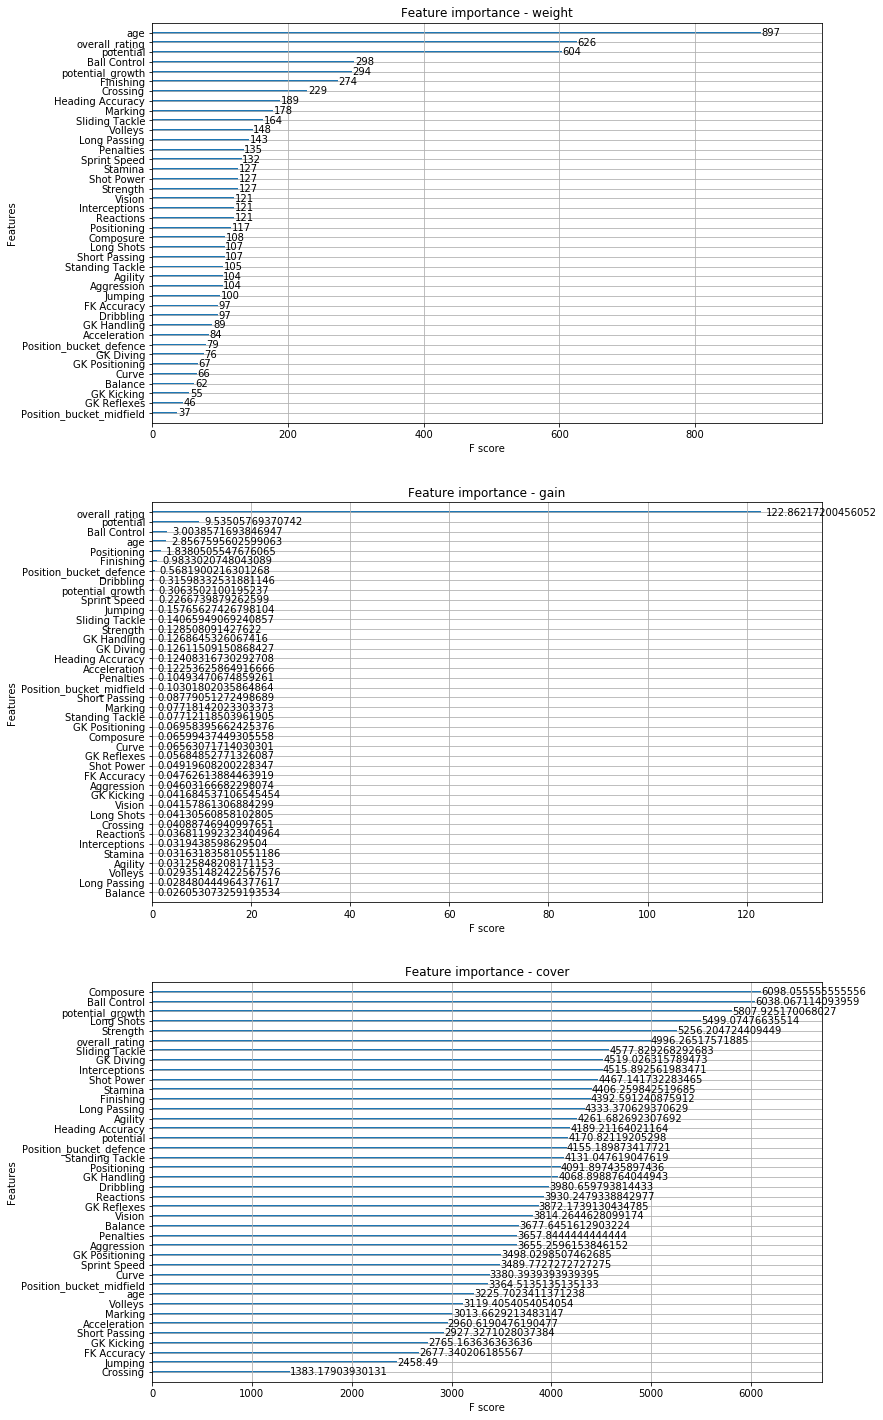

In [52]:
fig, ax = plt.subplots(nrows=3,figsize=(12,25))

for idx, importance_type in enumerate(['weight','gain','cover']):
    xgboost.plot_importance(xgb_model,importance_type=importance_type,ax=ax[idx])
    ax[idx].set_title(f"Feature importance - {importance_type}")

plt.show()

The feature importances for each method are very different, which doesn't give much confidence in correctly interpreting the most important features.

A better method is to use SHAP values which give more insight into how each feature affects the model output. Instead of using feature importance bar chars, we can use a density scatter plot of SHAP values for each feature. This allows us to identify how much impact each feature has on the model output for datapoints in the test set. The features are ordered by the sum of the SHAP value magnitudes across all samples. 

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the relative feature value of that datapoint.

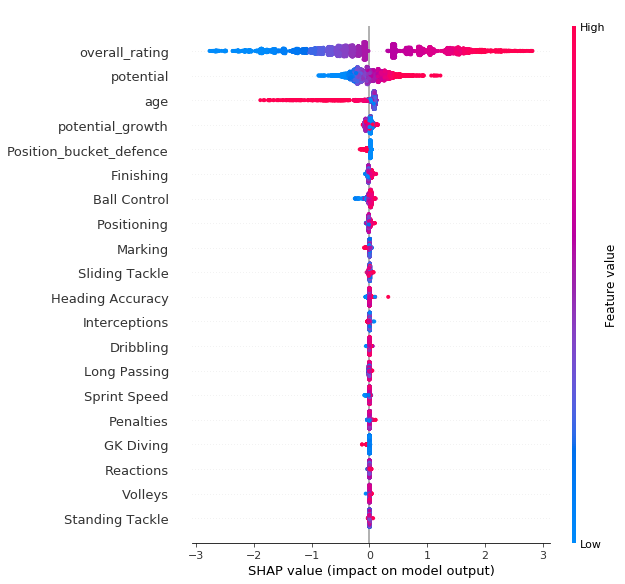

In [53]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_shap)

display(HTML("<h4>XGBoost model feature importance - SHAP value summary plot</h4>"))

#plot a summary
shap.summary_plot(shap_values,X_test_shap)

From the summary plot above we can see that overall rating, potential and age have the biggest impact on the model output. As we would expect, having a higher overall rating and potential increases the value of the player. Interestingly we can see that for most datapoints, age does not have a big impact, but for those datapoints where it is important, it starts to have a big negative effect on final prediction. The colourbar shows that the higher the age (red datapoints), the bigger the negative impact. 

Looking further down the chart, we see that the individual playing attributes do not contribute significantly to the model output. We can also see that the player position does not have a material effect on the model output. Presumably because the player position is implied by the relative strengths and weaknesses in their playing attributes.

Keeping all of these player attributes in the model increases complexity but without adding significant predictive power. I believe there is still important information contained in these features so they shouldn't be dropped completely, therefore, I will summarise the attributes into more general categories (e.g. attacking skills, defending skills etc.) to keep some of the important information about each player but reduce dimensionality of the data set.

<a id='fe'></a>
### 3.1 Feature engineering

- Combine playing attributes into general categories
    - calculate the average score of attributes within each category

In [54]:
skills_dict = {
    'Attacking': ['Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys'],
    'Skills': ['Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control'],
    'Movement': ['Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance'],
    'Power': ['Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots'],
    'Mentality': ['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure'],
    'Defending': ['Standing Tackle', 'Sliding Tackle', 'Marking'],
    'Goalkeeping': ['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes']

}

In [55]:
#function to create new features from raw data
def make_fe_data_set(skills_dict=skills_dict):
    """make dataset with engineered features (consolidate individual player attributes)"""
    
    #load raw data
    raw_df = pd.read_csv("data/1. processed/data_clean.csv")    
    df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

    #select sensible features
    df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']].copy()
    
   
    #drop missing position datapoints
    df = df.loc[df['Position'].notnull()].copy()
    
    #create player position buckets
    df['Position_bucket'] = df['Position'].apply(bucket_positions) 
    del df['Position']
    
    #create new feature for potential growth
    df['potential_growth'] = df['potential']-df['overall_rating']
    
    
    #combine attribute features
    for skill_cat, skills in skills_dict.items():
        df[skill_cat] = df[skills].mean(axis=1)
    
    #log transform value_clean attribute
    df['target'] = np.log(df['value_clean'])
    del df['value_clean']
    
    
    keep_cols = [col for col in df.columns if col not in ATTRIBUTES ]
    df = df[keep_cols].copy()
    
    #make sure no missing data
    assert df.isnull().sum().sum() == 0
    
    #shuffle the dataframe just incase their was any bias in the order that the data was collected
    df_shuffled = shuffle(df, random_state=0)


    #create train and test split
    return train_test_split(df_shuffled.iloc[:,:-1],
                            df_shuffled.iloc[:,-1],
                            test_size=0.33,
                            random_state=0)
    

- create featured engineered (fe) datasets

In [56]:
X_train_fe,X_test_fe,y_train_fe,y_test_fe = make_fe_data_set()

In [57]:
#new dataset for modeling
X_train_fe.head()

,age,overall_rating,potential,Position_bucket,potential_growth,Attacking,Skills,Movement,Power,Mentality,Defending,Goalkeeping
104,18,66,82,midfield,16,51.8,61.4,72.0,55.6,54.666667,41.000000,9.8
3367,31,76,76,midfield,0,68.6,77.8,76.0,71.6,67.333333,27.666667,9.6
4816,21,67,75,midfield,8,61.8,61.8,68.2,65.8,55.500000,31.000000,9.6
11395,24,59,65,midfield,6,48.4,54.4,71.2,52.8,50.500000,27.666667,9.8
11263,24,60,64,midfield,4,52.0,56.2,64.8,57.0,46.833333,37.333333,11.2


- preprocess the data

In [58]:
numeric_features = X_train_fe.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_fe.select_dtypes(include=['object']).columns

scaler = StandardScaler().fit(X_train_fe[numeric_features])
X_train_fe[numeric_features] = scaler.transform(X_train_fe[numeric_features])
X_train_fe = pd.get_dummies(X_train_fe,drop_first=True)

- retrain model

In [59]:
param_grid = {
    "n_estimators": [10, 50, 100, 500, 1000],
    "learning_rate": [0.1, 0.5, 1]
}



xgb_fe_model = GridSearchCV(XGBRegressor(random_state=0), cv=CV_FOLDS, 
                    param_grid=param_grid,
                    n_jobs=N_JOBS,verbose=VERBOSE)

xgb_fe_model.fit(X_train_fe,y_train_fe) 

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished


[08:49:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100, 500, 1000], 'learning_rate': [0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

- make predictions on test set

In [60]:
#create test set
#apply training set scaler to test set
X_test_fe[numeric_features] = scaler.transform(X_test_fe[numeric_features]) 
X_test_fe = pd.get_dummies(X_test_fe,drop_first=True)

{'learning_rate': 0.1, 'n_estimators': 1000}
RMSE: 0.07865384324886544


,rmse,adj. r2
XGBoost FE,0.078654,0.996748
XGBoost,0.079354,0.996672
Random Forest,0.167902,0.985099
Decision Tree,0.197168,0.979451
Multiple Linear Regression,0.250560,0.967403
Multiple Linear Regression - Backward Elimination,0.252326,0.967028
XGBoost w/PCA,0.278596,0.958974
Random Forest w/PCA,0.425746,0.904190
baseline model (linear regression),0.438973,0.900383
Decision Tree w/PCA,0.533455,0.849580


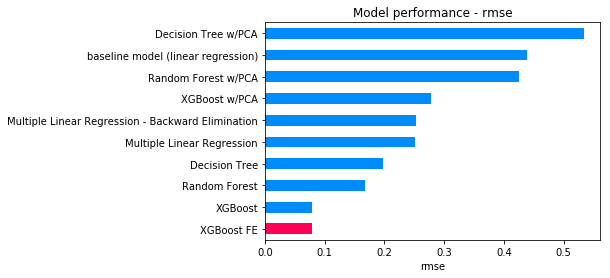

In [61]:
xgb_fe_predict = xgb_fe_model.predict(X_test_fe)

xgb_fe_RMSE = np.sqrt(mean_squared_error(y_test_fe, xgb_fe_predict))

print(xgb_fe_model.best_params_)
print(f"RMSE: {xgb_fe_RMSE}")

model_results['XGBoost FE'] = {'rmse':xgb_fe_RMSE,
                              'adj. r2':calc_adj_r2(X_test_fe,r2_score(y_test_fe,xgb_fe_predict))}

display(pd.DataFrame.from_dict(model_results,orient='index').sort_values('rmse'))
pd.DataFrame.from_dict(model_results,orient='index').sort_values('rmse')['rmse'].plot(kind='barh',
                                                                                      color=['#ff0055'] + ['#008bfb']*9)
plt.title("Model performance - rmse")
plt.xlabel("rmse")
plt.show()

Reducing the feature space has actually increased (marginally) the performance of the model, whilst reducing the complexity.

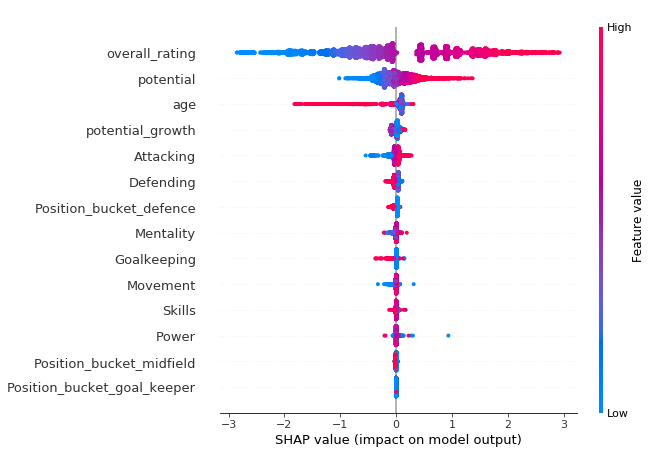

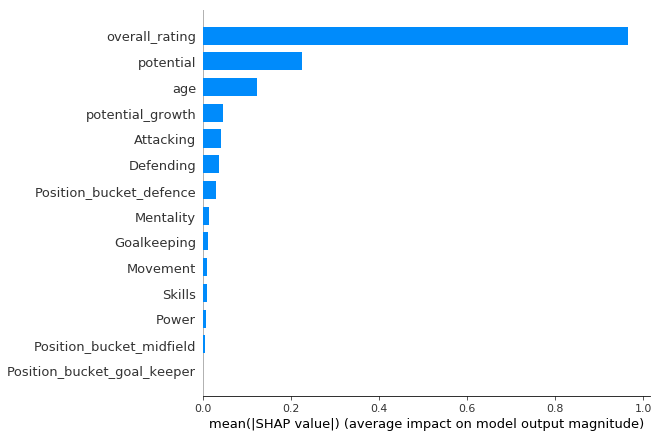

In [62]:
#shap values
explainer_fe = shap.TreeExplainer(xgb_fe_model.best_estimator_)
shap_values_fe = explainer_fe.shap_values(X_train_fe)

#plot a summary
shap.summary_plot(shap_values_fe,X_train_fe)

#summary as a bar chart
shap.summary_plot(shap_values_fe, X_train_fe, plot_type="bar")

Once again, overall rating, potential and age have the largest effects on the model output. By grouping the playing attributes into more general categories we can see that each category has an overall larger effect on the model output compared to when the individual attributes were used.

The engineered feature of potential_growth is also somewhat important, with players that have a higher growth potential demanding premium valuations.

Interestingly we can see that attacking attributes are important for improving a player's value, especially if the player has poor attacking skills.

To investigate the effect of each feature on model output further, we can plot the SHAP value versus each feature (note that the feature values have been scaled).

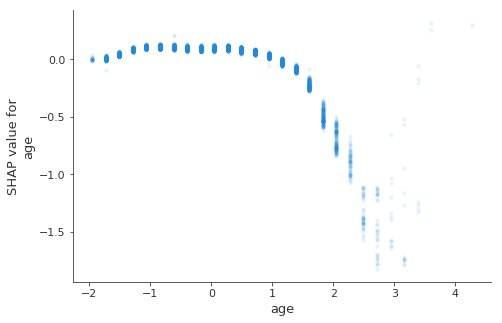

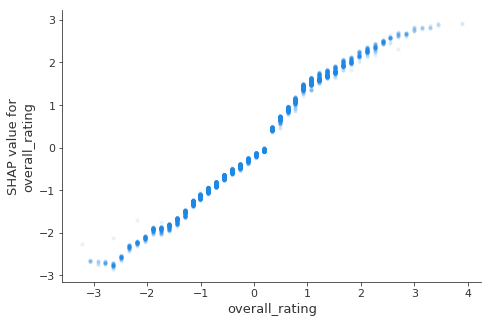

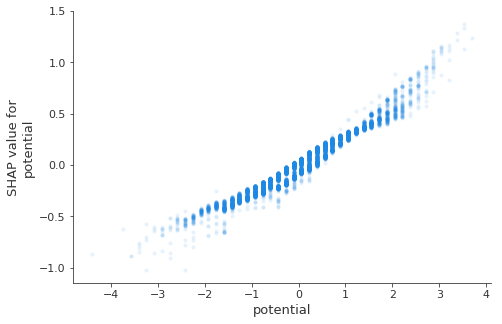

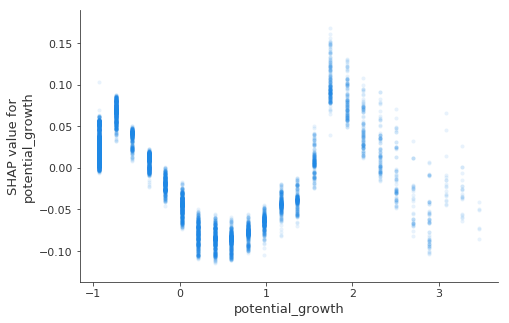

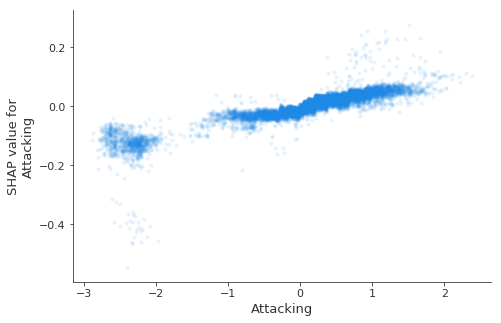

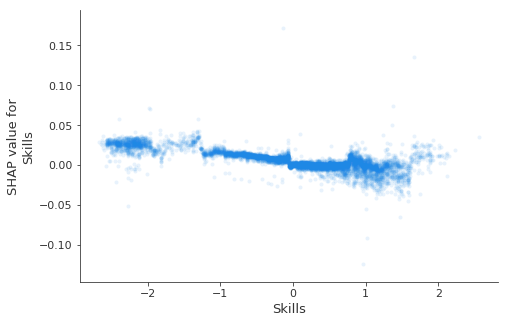

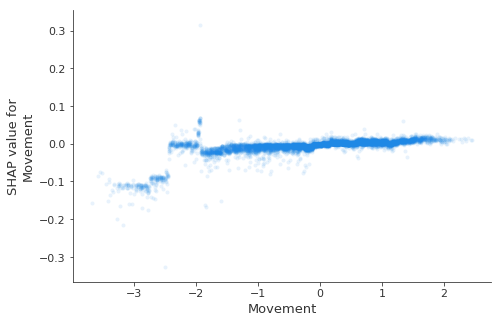

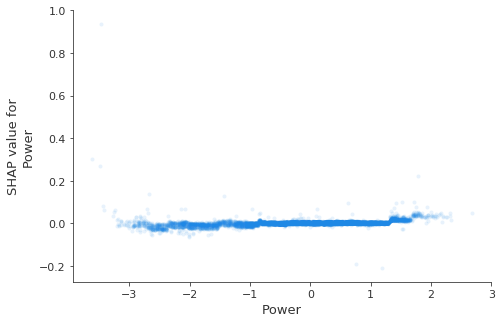

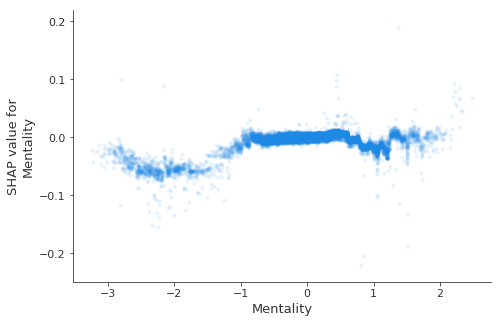

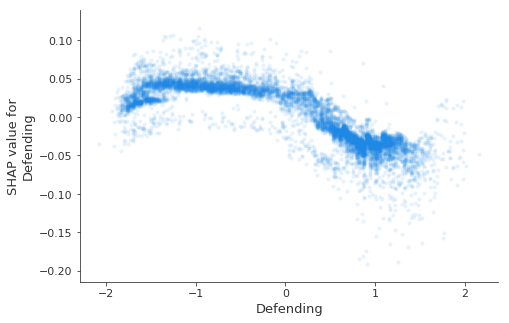

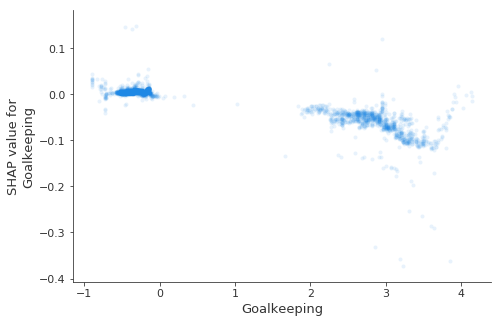

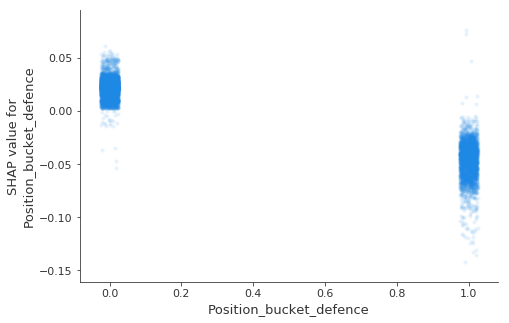

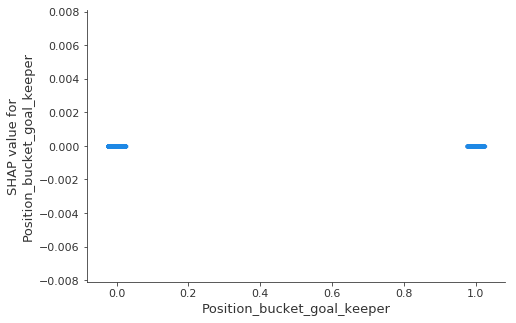

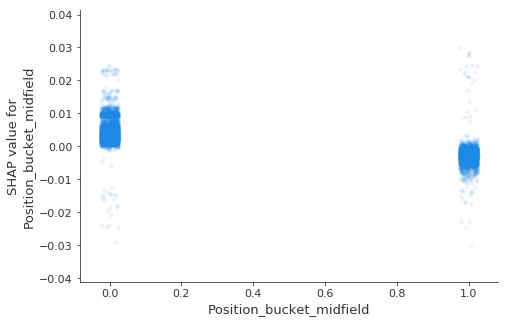

In [63]:
for name in X_train_fe.columns:
    if name in X_train_fe[numeric_features]:
        shap.dependence_plot(name, 
                             shap_values_fe, 
                             X_train_fe,
                             interaction_index=None,
                             alpha=0.1)
    else:
        shap.dependence_plot(name, 
                             shap_values_fe, 
                             X_train_fe,
                             interaction_index=None,
                             alpha=0.1,
                             x_jitter=0.05)

<a id='iovp'></a>
# 4. Identifying over/under valued players

We can use the model to help identify players which are over or under valued in the market.

- retrain the model on the full dataset and compare the actual and predicted values of the players.

In [64]:
full_data_features = X_test_fe.append(X_train_fe)
full_data_target = y_test_fe.append(y_train_fe)

assert len(full_data_features)==len(full_data_target)

In [65]:
params = xgb_fe_model.best_params_

final_model = XGBRegressor(learning_rate = 0.1,
                           n_estimators = 1000).fit(full_data_features,full_data_target)

[08:50:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [66]:
dump_file = 'final_model.pkl'
joblib.dump(final_model, dump_file, compress=1)
print(f"Saved best model to to file: {dump_file}")

Saved best model to to file: final_model.pkl


In [67]:
final_model = joblib.load('final_model.pkl')

[08:50:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


- add back the player names to the dataset to help identify players which are under or overvalued according to the model.

In [68]:
pred_analysis_df = raw_df[['name','country','age','overall_rating','Position','value_clean']]
pred_analysis_df['Position'] = pred_analysis_df['Position'].apply(bucket_positions)
pred_analysis_df = pred_analysis_df.dropna()

assert pred_analysis_df.isnull().sum().sum() == 0

- add predictions to the dataframe

In [69]:
#make final predictions on reordered dataframe
final_predictions = final_model.predict(full_data_features.sort_index())


pred_analysis_df['predicted_value'] = np.exp(final_predictions)
pred_analysis_df['difference'] = pred_analysis_df['value_clean']-pred_analysis_df['predicted_value']
pred_analysis_df['difference_pct'] = (pred_analysis_df['difference']/pred_analysis_df['value_clean'])*100

In [70]:
pred_analysis_df.float_format = '{:,.0f}'.format
pred_analysis_df.head()

,name,country,age,overall_rating,Position,value_clean,predicted_value,difference,difference_pct
0,Dayotchanculle Upamecano,France,19,77,defence,13000000.0,12633372.0,366628.0,2.820215
1,Renato Júnior Luz Sanches,Portugal,20,75,midfield,10000000.0,10711277.0,-711277.0,-7.112770
2,Juan Marcos Foyth,Argentina,20,74,defence,8500000.0,8790209.0,-290209.0,-3.414224
3,Wuilker Faríñez,Venezuela,20,73,goal_keeper,7500000.0,7178213.0,321787.0,4.290493
4,Thiago Alcântara do Nascimento,Spain,27,87,midfield,51500000.0,51641992.0,-141992.0,-0.275713


### Identify overvalued players

Specifically I will look at players who are undervalued from England.

In [71]:
def get_top_player_mismatch(method, df = pred_analysis_df,n=10):
    """Get the top player relative mismatch between actual and predicted value
    
    method = 'under' or 'over'
    n = int, number of players to return
    
    """
    assert method in ['undervalued','overvalued']
    
    if method == 'undervalued':
        return df.nsmallest(n,'difference_pct')
    else:
        return df.nlargest(n,'difference_pct')

In [72]:
#get top 10 overvalued players
display(HTML("<h3>Top 10 overvalued players from England</h3>"))
get_top_player_mismatch('overvalued',df=pred_analysis_df.loc[(pred_analysis_df['country']=='England')&
                                                             (pred_analysis_df['value_clean']>20_000)])

,name,country,age,overall_rating,Position,value_clean,predicted_value,difference,difference_pct
6206,Dean Marney,England,34,67,midfield,375000.0,2.809261e+05,9.407391e+04,25.086375
12116,David Perkins,England,36,65,midfield,170000.0,1.299228e+05,4.007724e+04,23.574848
1600,Adebayo Akinfenwa,England,36,66,attack,230000.0,1.880056e+05,4.199441e+04,18.258437
9161,Matt Bloomfield,England,34,63,midfield,180000.0,1.494351e+05,3.056489e+04,16.980495
12245,Christopher Hamilton,England,23,66,defence,925000.0,7.827488e+05,1.422512e+05,15.378507
5745,Jack Cork,England,29,76,midfield,7500000.0,6.386116e+06,1.113884e+06,14.851793
12855,Tommy Rowe,England,29,67,midfield,750000.0,6.433922e+05,1.066078e+05,14.214367
9205,Darren Pratley,England,33,66,midfield,375000.0,3.225915e+05,5.240850e+04,13.975600
7652,Jabo Ibehre,England,35,59,attack,70000.0,6.067787e+04,9.322133e+03,13.317333
5331,Levi Sutton,England,21,60,defence,290000.0,2.520315e+05,3.796853e+04,13.092597


[Dean Marney](https://en.wikipedia.org/wiki/Dean_Marney_(footballer)) is the most overvalued English player in the dataset at a 25% premium to his predicted value of &euro;281,000. He is a midfielder for Fleetwood Town who are currently in League One. Previously he has played for Premiership teams such as Tottenham Hotspur, Norwich City, Hull City and Burnely. Perhaps his reputation for playing at these big clubs has led to his overvaluation for his skills/age profile.

Once again we can use SHAP values to investigate how the model came to its prediction:

In [73]:
#shap values
explainer_fe = shap.TreeExplainer(final_model)
shap_values_full = explainer_fe.shap_values(full_data_features.sort_index())

In [74]:
def investigate_prediction(index,name):
    display(HTML(f"<h4>{name} Prediction - SHAP values</h4>"))
    display(shap.force_plot(explainer_fe.expected_value,
                            shap_values_full[(np.where(full_data_features.sort_index().index==index)[0]),:],
                            full_data_features.columns))
    

investigate_prediction(6206,"Dean Marney")

Age, overall rating, potential and defending skills all a had negative impact on his predicted valuation. The SHAP force_plot shows that there were not any significant features which helped increase his valuation.

Notably, [Adebayo Akinfenwa](https://en.wikipedia.org/wiki/Adebayo_Akinfenwa) is also on the overvalued list. Fans of FIFA might know that he has a cult following on the game (and in real life), even though he only plays for a low league club, due to his unusual (larger) build compared to a typical football player. His popular reputation among fans and the media might be inflating his valuation.  

In [75]:
#investigate Adebayo Akinfenwa prediction in more detail
investigate_prediction(1600,"Adebayo Akinfenwa")

### Identify undervalued players

In [76]:
#get top 10 overvalued players
display(HTML("<h3>Top 10 undervalued players from England</h3>"))
get_top_player_mismatch('undervalued',df=pred_analysis_df.loc[(pred_analysis_df['country']=='England')&
                                                             (pred_analysis_df['value_clean']>20_000)])

,name,country,age,overall_rating,Position,value_clean,predicted_value,difference,difference_pct
9168,Gary O'Neil,England,35,67,midfield,180000.0,2.733090e+05,-93308.96875,-51.838316
13103,Matty Blair,England,29,65,midfield,400000.0,4.881799e+05,-88179.87500,-22.044969
7650,Karl Henry,England,35,67,midfield,180000.0,2.159892e+05,-35989.21875,-19.994010
12202,Gareth Barry,England,37,72,midfield,425000.0,5.048729e+05,-79872.87500,-18.793618
2263,Luke O'Nien,England,23,66,midfield,750000.0,8.740792e+05,-124079.25000,-16.543900
11344,Harry Pell,England,26,66,midfield,625000.0,7.240376e+05,-99037.56250,-15.846010
8471,Tom Hateley,England,28,68,midfield,725000.0,8.392409e+05,-114240.87500,-15.757362
12891,George Francomb,England,26,63,midfield,325000.0,3.742320e+05,-49231.96875,-15.148298
6714,Nathan Byrne,England,26,69,midfield,1000000.0,1.150460e+06,-150459.75000,-15.045975
10568,James Horsfield,England,22,63,midfield,400000.0,4.576239e+05,-57623.90625,-14.405977


In [77]:
investigate_prediction(9168,"Gary O'Neil")

Despite his age and lower overall rating, Gary O'Neil's predicted value is pushed up due to his attacking skills.

Of the other players in the list, Nathan Byrne has the highest valuation of &euro;1M. Given his skill profile and age the model predicts he should be worth &euro;1.15M. The force plot below shows that his defending skills are currently letting him down significantly.

In [78]:
investigate_prediction(6714,"Nathan Byrne")

<a id='conclusion'></a>
## 5. Conclusion

Player attributes, age and position can be used to predict the value of football players. The overall rating, potential and age of a player was found to have the most significant impact for predicting the value of each player. Individual playing attributes were found to be not economically significant, however, when grouping similar attributes together to reduce the number of features, attacking skills had the greatest effect on the value of each player. The favoured position of the player had little predictive power. 

The model was also used to identify under and overvalued players relative to the market. When specifically looking at overvalued players from England, it was noted that fame and popularity might be an important factor missing from the model.

--------------------

## Future Work

- expose the machine learning model to a user interface (e.g. webapp ([dash](https://plot.ly/dash/) or [streamlit](https://streamlit.io/)) so that the user can input their own data and get a prediction for the value of a player with those attributes 
- incorporate different features into the model such as current league/country or commercial factors such as social media following and brand appeal
- link the value of each player to their on pitch performance (e.g. number of career goals/clean sheets, number of goals last season etc.)
- collect data from different time periods to predict which players are likely to increase in value and what factors are most predictive
    - from example, collect data from 2/3 years ago and compare how the values of each football player (still playing) has changed. 


## Resources

**Data**
- Original data scraped from the [SOFIFA website](www.sofifa.com)
- see **data_collection** folder in repository for scraper - note that it may not work if the website layout has been changed


**Articles**

- [Managing machine learning workflows - Matthew Mayo, KDnuggets](https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html)
- [Interpretable Machine Learning - Scott Lundberg, TowardsDataScience](https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html)
- [Shap-values - Kaggle](https://www.kaggle.com/dansbecker/shap-values)
- [Decision tree regressor explained - George Drakos](https://gdcoder.com/decision-tree-regressor-explained-in-depth/)
- [Feature selection techniques - Gabriel Azevedo, TowardsDataScience
](https://towardsdatascience.com/feature-selection-techniques-for-classification-and-python-tips-for-their-application-10c0ddd7918b)
- [Machine Learning data pipelines - TowardsDataScience](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65)

----------------------


## Appendix: Simple supervised clustering

One future direction for further analysis could be using the SHAP values for cluster analysis to gain more insight into the predictions and the different types of players in the dataset. The short analysis below highlights clearly defined clusters of datapoints from their SHAP values.

In [79]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

#reduce dimensions
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values_full[:1000,:])

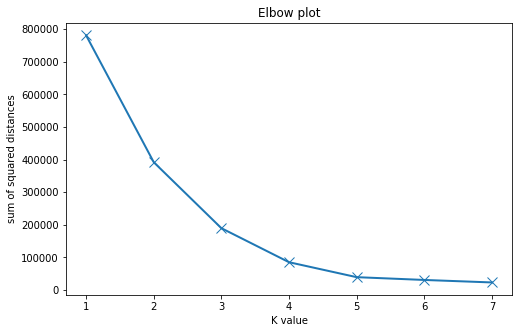

In [80]:
#find optimium clusters
distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(shap_embedded)
    distances.append(km.inertia_)
    
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,8),distances,marker='x',linewidth=2,markersize=10)
plt.title('Elbow plot')
plt.xlabel('K value')
plt.ylabel('sum of squared distances')
plt.show()

In [81]:
km = KMeans(n_clusters=4,random_state=0)
km = km.fit(shap_embedded)
labels = km.labels_

In [82]:
color_dict = dict(zip(list(range(4)),sns.color_palette("hls", 6)))
colors = [color_dict[label] for label in labels]

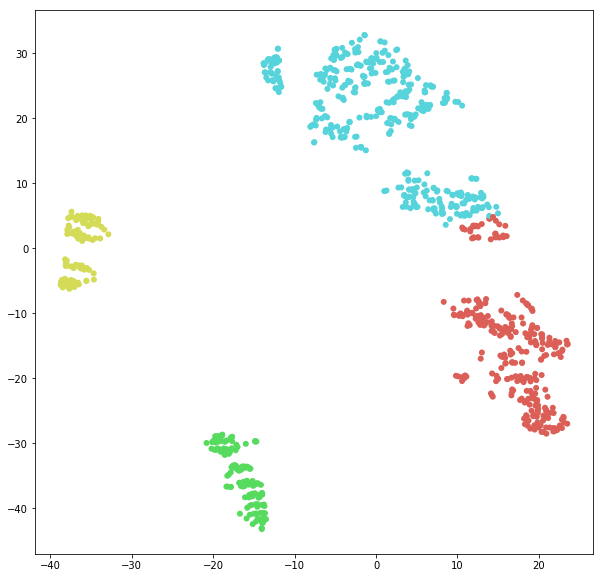

In [83]:
f = plt.figure(figsize=(10,10))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
            c=colors,
           linewidth=0, alpha=1.)

plt.show()